In [107]:
%autoreload 2
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random
from tqdm import tqdm

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteMap, FiniteVec, inner, SpVec, CombVec, RolloutSpVec, CovOp, CrossCovOp
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel, LinearKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from jaxrk.reduce import SparseReduce, LinearReduce
from jaxrk.kern import median_heuristic
from sklearn.datasets import make_moons
from copy import copy
from data import Traffic


traf = Traffic()

idx_out = 40
n = 20
use_inner = "gen_gauss"

traf.data['train'] = Traffic.equalize_smp_size(traf.data['train']).values.reshape(-1, 144, traf.data['test'].shape[-1])
traf.data['test'] = traf.data['test'].values.reshape(-1, 144, traf.data['test'].shape[-1])

In [108]:
traf.data['train'].shape, un.shape

((224, 144, 965), (902,))

In [109]:
(train_inp, train_out) = (traf.data['train'][:idx_out, :-1, 1:3].reshape((-1, 2)),
                          traf.data['train'][:idx_out, 1:, 2:3].reshape((-1, 1)))
un, cts, sr = LinearReduce.sum_from_unique(train_out.flatten(), mean=True)
A = sr.linear_map
C_inv = np.diag(1./A.max(1))
C = np.diag(A.max(1))
B = A.T@C
#sr.regul = 0.01
num_points_per_obs = 143
obs_median = 0.84 #0.9 #median_heuristic(traf.data['train'][:14, :-1, 2].reshape((-1, 1)), "sqeuclidean")
idx_median = 6.3504e+08 #1e+5 #median_heuristic(traf.data['train'][:14, :-1, 1:2].reshape((-1, 1)), "sqeuclidean")
print(obs_median, idx_median)

out_kern = GaussianKernel(obs_median)
period = traf.data['train'][:, :, 1:2].max()
idx_kern = PeriodicKernel(period, 1)
#idx_kern = GaussianKernel(idx_median)
in_kern = SplitDimsKernel([0, 1, 2], [idx_kern, out_kern])

inp_vec_gr = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, gram_reduce =sr, use_inner=use_inner)
out_vec_gr = FiniteVec(out_kern, un[:, np.newaxis],)

inp_vec = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner)
out_vec = FiniteVec(out_kern, train_out)


0.84 635040000.0


In [110]:
e = 0.24*2 #e = 2*b
ei = 1./e
c = 0.9

In [111]:
O = Cmo(inp_vec, out_vec, 1./cts.sum()**(e*c))
test_inp = traf.data['test'][:1, :n, 1:3].reshape((-1, 2))
#test_inp[:, 1:] = stats.norm.ppf(to.cdf(test_inp[:, 1:]))
test_out = traf.data['test'][:1, n:, 2:3]
#test_out = stats.norm.ppf(to.cdf(traf.data['train'][idx_out, n:, 2:3]))
inp_test = SpVec(in_kern, test_inp, np.array([n]), use_subtrajectories = False, use_inner=use_inner)

cur_ro = RolloutSpVec(O, inp_test, 1)
rval = []
for i in tqdm(range(1, 144-n)):
    new_point = cur_ro.current_outp_emb.point_representant()
    rval.append(new_point)
    cur_ro.update(new_point)

100%|██████████| 123/123 [00:50<00:00,  2.42it/s]


In [112]:
if False:
    G= inp_vec.inner()
    G_inv = np.linalg.inv(G + alpha * np.eye(G.shape[0]))
    G_tilde = A@G@A.T
    rval = A.T@np.linalg.inv(G_tilde+alpha * C_inv)@A
    true_diag = (1./(np.diag(G) + alpha))
    sqr_frac = np.sqrt(true_diag/np.diag(rval))
    f = np.outer(sqr_frac, sqr_frac)

In [113]:
def redInvBu(G, correct = False):
    G_tilde = A@G@A.T
    rval = A.T@np.linalg.inv(G_tilde+alpha * C_inv)@A
    if not correct:
        return rval
    else:
        true_diag = (1./(np.diag(G) + alpha))
        sqr_frac = np.sqrt(true_diag/np.diag(rval))
        f = np.outer(sqr_frac, sqr_frac)
        return rval * f

In [114]:
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 0.1/cts**0.1)
#O_gr = Cmo(inp_vec_gr, out_vec_gr, (cts/ cts.sum())**0.009)
cts_inv = np.diag(1./cts.squeeze())
alpha = 1./(cts.sum()**(e*c))
aI = alpha * np.eye(cts.size)
cn = C#/np.diag(C).sum()*20



O_gr = {
        #"redInvBuCorr":Cmo(inp_vec, out_vec, regul_func=lambda G: redInvBu(G, True)),
       # "redInvBu":Cmo(inp_vec, out_vec, regul_func=redInvBu ),
       # "rvecInv":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: C@np.linalg.inv(C@G_tilde@C+alpha * C)@C),
       "rveNormal":Cmo(inp_vec_gr, out_vec_gr, aI),
        "rvecInv2":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: np.linalg.inv(G_tilde+alpha * C_inv)),
       # "rvecInvAvg":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: (np.linalg.inv(G_tilde+alpha * C_inv) + C@np.linalg.inv(cn@G_tilde@cn+alpha * cn)@C)/2),
        }
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 1./(cts * (cts.sum()**0.049))) #:

In [115]:
inp_test = SpVec(in_kern, test_inp, np.array([n]), use_subtrajectories = False, use_inner=use_inner)
rval_gr={}
for k in O_gr:
    cur_ro_gr = RolloutSpVec(O_gr[k], inp_test, 1)
    rval_gr[k] = []
    for i in tqdm(range(1, 144-n)):
        new_point_gr = cur_ro_gr.current_outp_emb.point_representant()
        rval_gr[k].append(new_point_gr)
        cur_ro_gr.update(new_point_gr)

100%|██████████| 123/123 [00:23<00:00,  5.34it/s]


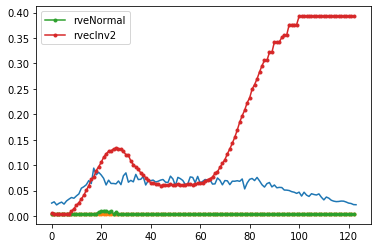

In [116]:
pl.plot(test_out.squeeze())
pl.plot(np.array(rval), ".-")
for k in rval_gr:
    pl.plot(np.array(rval_gr[k]).squeeze(), ".-", label=k)
pl.legend(loc="best")
#pl.plot(np.array(rval_gr2), ":")